In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from scipy import stats

In [32]:
df_train = pd.read_csv('train.csv')

In [33]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# SalePrice - target variable. 
Это хотим предсказать. Проанализируем переменную.

In [34]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

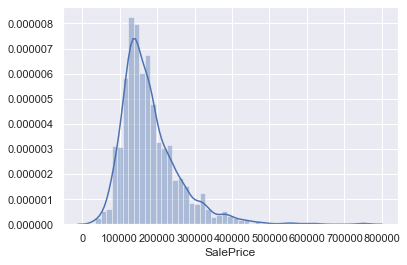

In [35]:
sns.distplot(df_train['SalePrice'])

# Связь с другими переменными

Кажется, что GrLivArea и LotArea должны хорошо отражать стоимость жилья.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


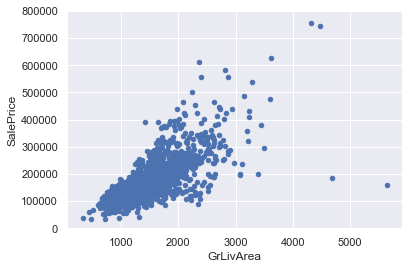

In [36]:
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


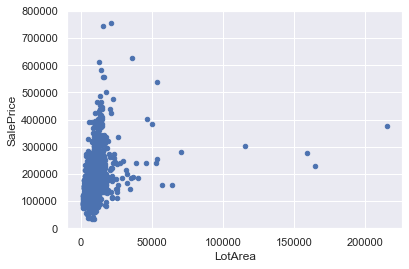

In [37]:
var = 'LotArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

Очевидно, что чем выше OverallQual, тем выше стоимость. Проверим это.

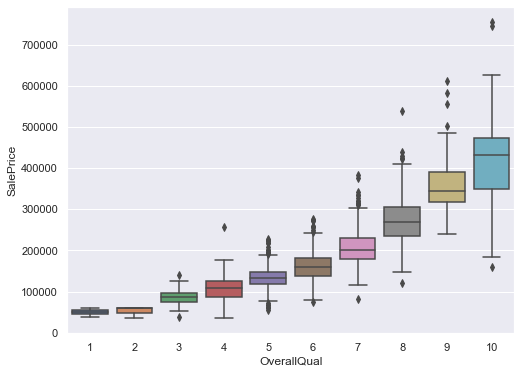

In [38]:
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)

Рассматривать каждую переменную в таком стиле очень долго. Поэтому предлагаю построить корреляционную матрицу.

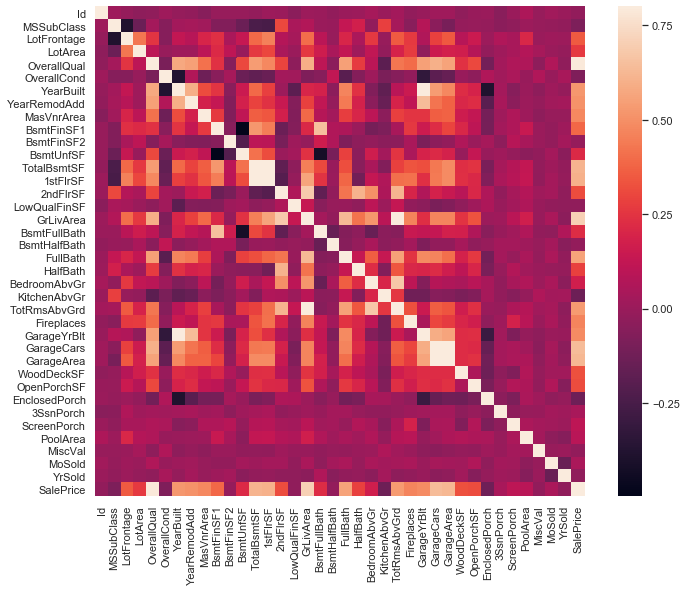

In [39]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

Очень здорово! Но матрица очень большая и на ней ничего не видно! Попробуем отобрать только некоторые признаки и сравнить их между собой.

In [40]:
k =10
cols = np.abs(corrmat).nlargest(k, 'SalePrice')['SalePrice'].index

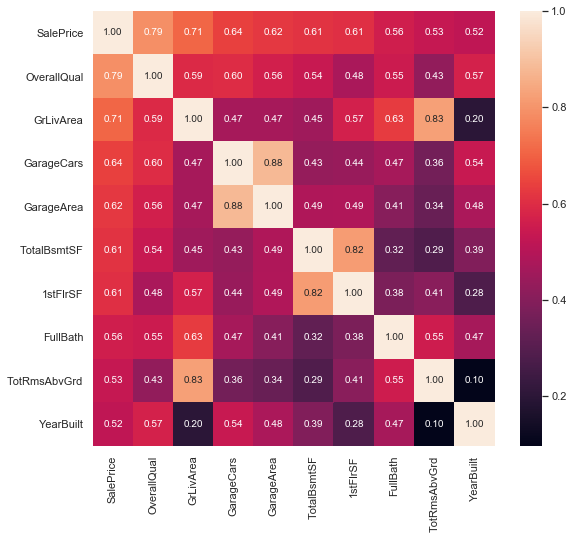

In [41]:
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.)
f, ax = plt.subplots(figsize=(9, 8))
hm = sns.heatmap(cm, cbar=True, annot=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values, ax=ax)
plt.show()

Теперь проведем более подробный анализ этих переменных

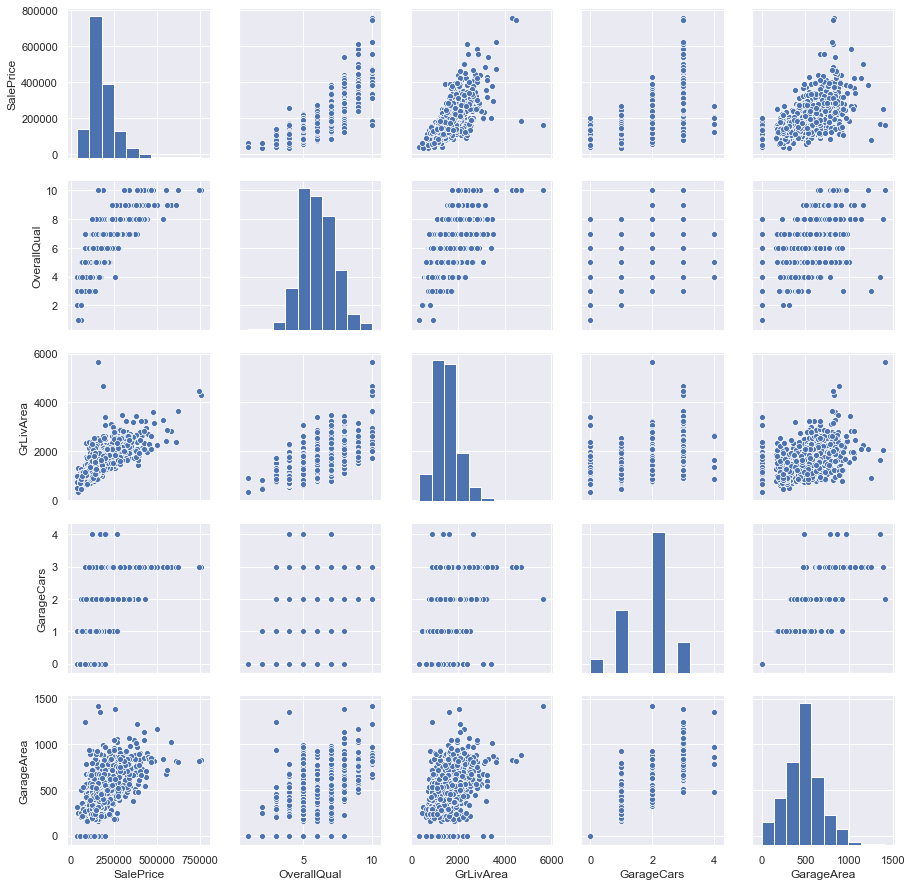

In [42]:
sns.pairplot(df_train[cols[:5]], height = 2.5)
plt.show()

# Missing values
Похоже, что в GarageArea есть пропущенные значения. 
Надо разобраться с ними и в других переменных.

In [43]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [44]:
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


Можем попытаться как-то заполнить пропущенные значения, но для фичи где таких значений более 15-20% лучше удалить.

In [28]:
df_train.groupby('PoolArea').agg({'PoolQC': lambda x: np.sum(pd.isna(x))})

,PoolQC
PoolArea,
0,1453
480,0
512,0
519,0
555,0
576,0
648,0
738,0


Оказывается, если бассейна в доме нет, то тогда ставится None. Неприятно =(

К счастью, только в 0.5% домов есть бассейн. Можем заняться небольшим feature engineering. Для этих фичей NA значит, что такие блага отсутствуют в доме.

In [45]:
for i in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'MasVnrType']:
    df_train[i] = df_train[i].fillna("None")

Для этих фичей предполагается то же самое, но они числовые.

In [46]:
for i in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
          'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
    df_train[i] = df_train[i].fillna(0)

In [47]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [48]:
missing_data.head(10)

,Total,Percent
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479
BsmtFinType2,38,0.026027
BsmtExposure,38,0.026027
BsmtFinType1,37,0.025342
BsmtCond,37,0.025342
BsmtQual,37,0.025342


Дропнем остальное за ненадобностью

In [49]:
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max()

0

Теперь можем начать обучать модели. Или разбираться с выбросами в данных. Попробуем обучить простую модель на нынешних данных. Затем разберемся с выбросами.

Имеет смысл некоторые числовые фичи сделать категориальными, например годы и месяцы, общую оценку дома и класс здания

In [234]:
df_train['MSSubClass'] = df_train['MSSubClass'].apply(str)
df_train['OverallCond'] = df_train['OverallCond'].astype(str)
df_train['YrSold'] = df_train['YrSold'].astype(str)
df_train['MoSold'] = df_train['MoSold'].astype(str)

df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']

Отлично! Теперь энкодируем их в категориальные фичи. Этого можно не делать для алгоритма Catboost. Поэтому попробует сделать и так и так.

In [235]:
real_features = []
cat_features = []

In [236]:
for k, v in zip(dict(df_train.dtypes).keys(), dict(df_train.dtypes).values()):
    if k in ['Id', 'SalePrice']:
        continue
    if v=='object':
        cat_features.append(k)
    else:
        real_features.append(k)

In [237]:
cat_features

['MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition']

In [286]:
df_train_lb = df_train.copy()

In [287]:
cols = cat_features

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(df_train_lb[c].values)) 
    df_train_lb[c] = lbl.transform(list(df_train_lb[c].values))

In [200]:
df_train_lb_bin = df_train.copy()

In [201]:
cols = cat_features + ['OverallQual', 'YearBuilt', 'OverallCond', 'YearRemodAdd']

for c in cols:
    lbl = LabelBinarizer() 
    tr = lbl.fit_transform(list(df_train_lb_bin[c].astype(str).values)) 
    names = [c+'_is_'+i for i in lbl.classes_]
    for n in names:
        df_train_lb_bin[n] = tr[:, 0]
df_train_lb_bin = df_train_lb_bin.drop(columns=cols)

Обучим одинаковые модели на одних данных и на других.

In [227]:
from catboost import Pool, CatBoostRegressor
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

In [239]:
n_folds = 5
train = df_train_lb.drop(columns=['Id', 'SalePrice'])
y_train = np.log1p(df_train_lb['SalePrice'].values)

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [246]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KNN = make_pipeline(RobustScaler(), KNeighborsRegressor())
catboost = make_pipeline(RobustScaler(), CatBoostRegressor(verbose=0))

In [247]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1490 (0.0261)



In [248]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1490 (0.0261)



In [249]:
score = rmsle_cv(KNN)
print("KNN score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

KNN score: 0.2597 (0.0151)



In [250]:
score = rmsle_cv(catboost)
print("Catboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Catboost score: 0.1219 (0.0117)



Пока catboost показывает лучший результат. Попробует использовать бинаризованные признаки.

In [251]:
train = df_train_lb_bin.drop(columns=['Id', 'SalePrice'])
y_train = np.log1p(df_train_lb_bin['SalePrice'].values)

In [252]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KNN)
print("KNN score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(catboost)
print("Catboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1705 (0.0316)

ElasticNet score: 0.1704 (0.0316)

KNN score: 0.2638 (0.0100)

Catboost score: 0.1412 (0.0120)



Нет. Качество не улучшилось. Предполагаю, что это из-за увеличившегося пространста признаков.
Остановимся на первой выборке. И вспомним про то, что мы еще не исправляли скошенные данные, для лассо и эластикнета это может быть довольно важно.

In [290]:
from scipy.stats import norm, skew

n_folds = 5
train = df_train_lb.drop(columns=['Id', 'SalePrice'])
y_train = np.log1p(df_train_lb['SalePrice'].values)

In [291]:
skewed = train[real_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,24.443278
PoolArea,14.807992
LotArea,12.190881
3SsnPorch,10.290132
LowQualFinSF,8.998885
KitchenAbvGr,4.482026
BsmtFinSF2,4.249219
ScreenPorch,4.116334
BsmtHalfBath,4.097541
EnclosedPorch,3.085342


In [292]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    train[feat] = boxcox1p(train[feat], lam)

There are 32 skewed numerical features to Box Cox transform


In [294]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KNN = make_pipeline(RobustScaler(), KNeighborsRegressor())
catboost = make_pipeline(RobustScaler(), CatBoostRegressor(verbose=0))

score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KNN)
print("KNN score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(catboost)
print("Catboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1350 (0.0160)

ElasticNet score: 0.1350 (0.0160)

KNN score: 0.2063 (0.0084)

Catboost score: 0.1207 (0.0114)



Смогли еще улучшить score.

In [296]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [303]:
averaged_models = AveragingModels(models = (ENet, lasso))

In [304]:
score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1350 (0.0160)



Видно, что модели обучились абсолютно одинаково. А значит создавать метамодель с данными моделями не имеет смысла. Нужны разные модели. Попробуем.

In [306]:
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KNN = make_pipeline(RobustScaler(), KNeighborsRegressor())
RFR = make_pipeline(RobustScaler(), RandomForestRegressor(n_estimators=25))
GBR = make_pipeline(RobustScaler(), GradientBoostingRegressor())

score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KNN)
print("KNN score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(RFR)
print("RFR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(GBR)
print("GBR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1350 (0.0160)

ElasticNet score: 0.1350 (0.0160)

KNN score: 0.2063 (0.0084)

RFR score: 0.1456 (0.0054)

GBR score: 0.1264 (0.0082)



In [307]:
averaged_models = AveragingModels(models = (ENet, lasso, KNN, RFR, GBR))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1309 (0.0110)



Качество улучшилось, но тем не менее не дотягивает до catboost. Значит дальше используем catboost.

Теперь соберем удачные подходы в один код и подготовим файл с предсказанием.

In [368]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

ntrain = train.shape[0]
ntest = test.shape[0]
y_train = np.log1p(train.SalePrice.values)

all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

C:\Users\iLeks\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [369]:
for i in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'MasVnrType']:
    all_data[i] = all_data[i].fillna("None")
    
for i in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
          'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
    all_data[i] = all_data[i].fillna(0)
    
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
all_data = all_data.drop((missing_data[missing_data['Total'] > 1]).index,1)
all_data = all_data.fillna(0)
all_data.isnull().sum().max()

0

In [370]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [371]:
cat_features = []
real_features = []
for k, v in zip(dict(all_data.dtypes).keys(), dict(all_data.dtypes).values()):
    if k in ['Id', 'SalePrice']:
        continue
    if v=='object':
        cat_features.append(k)
    else:
        real_features.append(k)

In [372]:
cols = cat_features

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

In [373]:
skewed = all_data[real_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed})
skewness = skewness[abs(skewness) > 0.75]

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

In [374]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [375]:
catboost = CatBoostRegressor(verbose=0)
catboost.fit(train.values, y_train)

In [376]:
pred = np.expm1(catboost.predict(test.values))

In [377]:
train_pred = catboost.predict(train.values)

In [378]:
from sklearn.metrics import mean_squared_error
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [379]:
rmsle(y_train, train_pred)

0.05294335327751347

In [380]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = pred
sub.to_csv('submission.csv',index=False)

In [381]:
test_ID.shape

(1459,)

In [382]:
pred.shape

(1459,)

In [388]:
model = CatBoostRegressor()

grid = {'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05],
        'depth': [2, 3, 4]}

grid_search_result = model.grid_search(grid, 
                                       X=train.values, 
                                       y=y_train, 
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.1276558	best: 0.1276558 (0)	total: 897ms	remaining: 12.6s
1:	loss: 0.1197390	best: 0.1197390 (1)	total: 1.65s	remaining: 10.7s
2:	loss: 0.1182780	best: 0.1182780 (2)	total: 2.4s	remaining: 9.6s
3:	loss: 0.1190713	best: 0.1182780 (2)	total: 3.15s	remaining: 8.65s
4:	loss: 0.1197534	best: 0.1182780 (2)	total: 3.87s	remaining: 7.75s
5:	loss: 0.1378413	best: 0.1182780 (2)	total: 4.87s	remaining: 7.3s
6:	loss: 0.1279428	best: 0.1182780 (2)	total: 5.88s	remaining: 6.73s
7:	loss: 0.1280519	best: 0.1182780 (2)	total: 6.91s	remaining: 6.04s
8:	loss: 0.1308494	best: 0.1182780 (2)	total: 7.91s	remaining: 5.28s
9:	loss: 0.1314721	best: 0.1182780 (2)	total: 8.95s	remaining: 4.48s
10:	loss: 0.1550511	best: 0.1182780 (2)	total: 10.3s	remaining: 3.75s
11:	loss: 0.1470590	best: 0.1182780 (2)	total: 11.8s	remaining: 2.94s
12:	loss: 0.1441105	best: 0.1182780 (2)	total: 13.2s	remaining: 2.03s
13:	loss: 0.1433548	best: 0.1182780 (2)	total: 14.6s	remaining: 1.04s
14:	loss: 0.1482882	best: 0.11827

In [390]:
grid_search_result['params']

{'depth': 2, 'learning_rate': 0.03}

In [392]:
catboost = CatBoostRegressor(verbose=0, **grid_search_result['params'])
catboost.fit(train.values, y_train)
pred = np.expm1(catboost.predict(test.values))
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = pred
sub.to_csv('submission.csv',index=False)